## Single Item Recommender System

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/single_item_recommender_system_example/single_item_recommender_system.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

In [1]:
%load_ext autoreload
%autoreload 2

I0421 182826.629 magics.py:84] %autoreload was called with parameter_s='2'


## Installation
If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.

In [ ]:
%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git
%cd Pearl
%pip install .
%cd ..

## Import Modules

In [2]:
import random
from typing import List, Optional, Tuple

import numpy as np

import torch
import torch.nn as nn
from pearl.action_representation_modules.identity_action_representation_module import (
    IdentityActionRepresentationModule,
)
from pearl.api.action import Action
from pearl.api.action_result import ActionResult
from pearl.api.action_space import ActionSpace
from pearl.api.environment import Environment
from pearl.api.observation import Observation
from pearl.history_summarization_modules.lstm_history_summarization_module import (
    LSTMHistorySummarizationModule,
)
from pearl.neural_networks.sequential_decision_making.q_value_networks import (
    EnsembleQValueNetwork,
)
from pearl.pearl_agent import PearlAgent
from pearl.policy_learners.sequential_decision_making.bootstrapped_dqn import (
    BootstrappedDQN,
)
from pearl.policy_learners.sequential_decision_making.deep_q_learning import (
    DeepQLearning,
)
from pearl.replay_buffers.sequential_decision_making.bootstrap_replay_buffer import (
    BootstrapReplayBuffer,
)
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import (
    FIFOOffPolicyReplayBuffer,
)
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.utils.instantiations.spaces.discrete_action import DiscreteActionSpace
import matplotlib.pyplot as plt

set_seed(0)

I0421 182832.528 box.py:26] Using 'gymnasium' package.
I0421 182832.531 box_action.py:27] Using 'gymnasium' package.
I0421 182832.533 discrete.py:24] Using 'gymnasium' package.
I0421 182832.535 discrete_action.py:27] Using 'gymnasium' package.
I0421 182833.764 font_manager.py:1550] generated new fontManager


## Load Environment
This environment's underlying model was pre-trained using the MIND dataset (Wu et al. 2020).
The model is defined by class `SequenceClassificationModel` below.
The model's state dict is saved in
tutorials/single_item_recommender_system_example/env_model_state_dict.pt

Each data point is:
- A history of impressions clicked by a user
- Each impression is represented by an 100-dim vector
- A list of impressions and whether or not they are clicked

The environment is constructed with the setup below. Note that this is a contrived example
to illustrate Pearl's usage, agent modularity and a subset of features,
not to represent a real-world environment or problem.
- State: a history of impressions by a user (note that we used the history of impressions
  instead of clicked impressions to speed up learning in this example).
  Interested Pearl users can change it to history of clicked impressions with much longer
  episode length and samples to run the following experiments.)
- Dynamic action space: two randomly picked impressions
- Action: one of the two impressions
- Reward: click
- Reset every 20 steps.


In [3]:
class SequenceClassificationModel(nn.Module):
    def __init__(
        self,
        observation_dim: int,
        hidden_dim: int = 128,
        state_dim: int = 128,
        num_layers: int = 2,
    ) -> None:
        super(SequenceClassificationModel, self).__init__()
        self.lstm = nn.LSTM(
            num_layers=num_layers,
            input_size=observation_dim,
            hidden_size=hidden_dim,
            batch_first=True,
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + observation_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )
        self.register_buffer(
            "default_cell_representation", torch.zeros((num_layers, hidden_dim))
        )
        self.register_buffer(
            "default_hidden_representation", torch.zeros((num_layers, hidden_dim))
        )

    def forward(self, x: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        h0 = (
            self.default_hidden_representation.unsqueeze(1)
            .repeat(1, batch_size, 1)
            .detach()
        )
        c0 = (
            self.default_cell_representation.unsqueeze(1)
            .repeat(1, batch_size, 1)
            .detach()
        )
        out, (_, _) = self.lstm(x, (h0, c0))
        mlp_input = out[:, -1, :].view((batch_size, -1))
        return torch.sigmoid(self.mlp(torch.cat([mlp_input, action], dim=-1)))


class RecEnv(Environment):
    def __init__(
        self, actions: List[torch.Tensor], model: nn.Module, history_length: int
    ) -> None:
        self.model: nn.Module = model.to(device)
        self.history_length: int = history_length
        self.t = 0
        self.T = 20
        self.actions: List[List[torch.Tensor]] = [
            [torch.tensor(k) for k in random.sample(actions, 2)] for _ in range(self.T)
        ]
        self.state: torch.Tensor = torch.zeros((self.history_length, 100)).to(device)
        self._action_space: DiscreteActionSpace = DiscreteActionSpace(self.actions[0])

    def action_space(self) -> ActionSpace:
        return DiscreteActionSpace(self.actions[0])

    def reset(self, seed: Optional[int] = None) -> Tuple[Observation, ActionSpace]:
        self.state: torch.Tensor = torch.zeros((self.history_length, 100))
        self.t = 0
        self._action_space: DiscreteActionSpace = DiscreteActionSpace(
            self.actions[self.t]
        )
        return [0.0], self._action_space

    def step(self, action: Action) -> ActionResult:
        action = action.to(device)
        action_batch = action.unsqueeze(0)
        state_batch = self.state.unsqueeze(0).to(device)
        reward = self.model(state_batch, action_batch) * 3  # To speed up learning
        true_reward = np.random.binomial(1, reward.item())
        self.state = torch.cat([self.state[1:, :].to(device), action_batch], dim=0)

        self.t += 1
        if self.t < self.T:
            self._action_space = DiscreteActionSpace(self.actions[self.t])
        return ActionResult(
            observation=[float(true_reward)],
            reward=float(true_reward),
            terminated=self.t >= self.T,
            truncated=False,
            info={},
            available_action_space=self._action_space,
        )

    def __str__(self) -> str:
        return self.__class__.__name__


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_id = 0 if torch.cuda.is_available() else -1

model = SequenceClassificationModel(100).to(device)
model.load_state_dict(torch.load("/data/sandcastle/boxes/fbsource/fbcode/pearl/tutorials/single_item_recommender_system_example/env_model_state_dict.pt"))
actions = torch.load("/data/sandcastle/boxes/fbsource/fbcode/pearl/tutorials/single_item_recommender_system_example/news_embedding_small.pt")
history_length = 8
env = RecEnv(list(actions.values())[:100], model, history_length)
observation, action_space = env.reset()
assert isinstance(action_space, DiscreteActionSpace)

# experiment code
number_of_steps = 100000
record_period = 400

## Vanilla DQN Agent
Able to handle dynamic action space but not able to handle partial observability and sparse reward.

episode 5, step 100, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=RecEnv
return: 1.0
episode 10, step 200, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=RecEnv
return: 2.0
episode 15, step 300, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=RecEnv
return: 1.0
episode 20, step 400, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=RecEnv
return: 2.0
episode 25, step 500, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=RecEnv
return: 0.0
episode 30, step 600, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=RecEnv
return: 4.0
episode 35, step 700, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=RecEnv
return: 0.0
episode 40, step 800, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=RecEnv
return: 4.0
episode 45, step 900, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=RecEnv
return: 1.0
episode 50, step 100

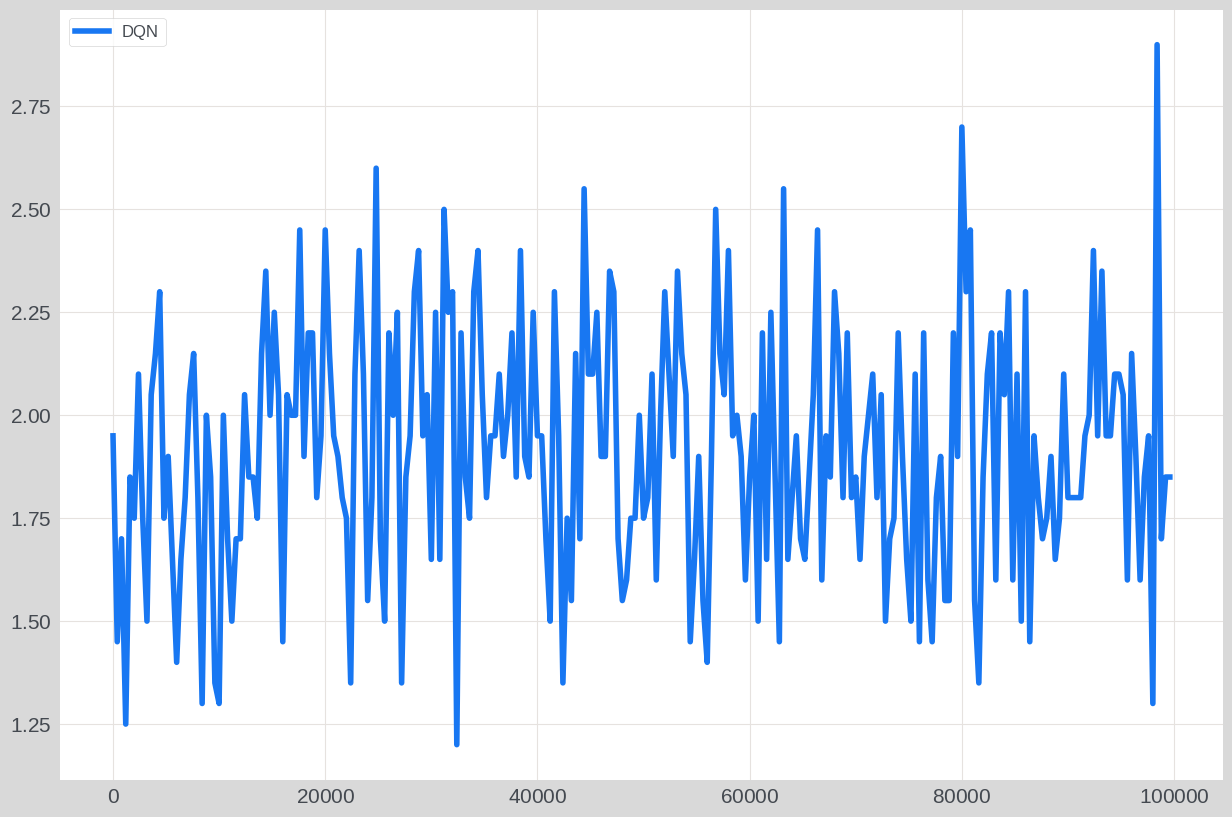

In [4]:
# create a pearl agent

action_representation_module = IdentityActionRepresentationModule(
    max_number_actions=action_space.n,
    representation_dim=action_space.action_dim,
)

# DQN-vanilla
agent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=1,
        action_space=action_space,
        hidden_dims=[64, 64],
        training_rounds=50,
        action_representation_module=action_representation_module,
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=device_id,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=min(record_period, number_of_steps),
    learn_after_episode=True,
)

torch.save(info["return"], "DQN-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="DQN")
plt.legend()
plt.show()

## DQN Agent with LSTM history summarization module

Now the DQN agent can handle partially observable environments with history summarization.

episode 5, step 100, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=RecEnv
return: 0.0
episode 10, step 200, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=RecEnv
return: 1.0
episode 15, step 300, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=RecEnv
return: 1.0
episode 20, step 400, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=RecEnv
return: 2.0
episode 25, step 500, agent=PearlAgent with DeepQLearning, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), FIFOOffPolicyReplayBuffer, env=RecEnv
return: 

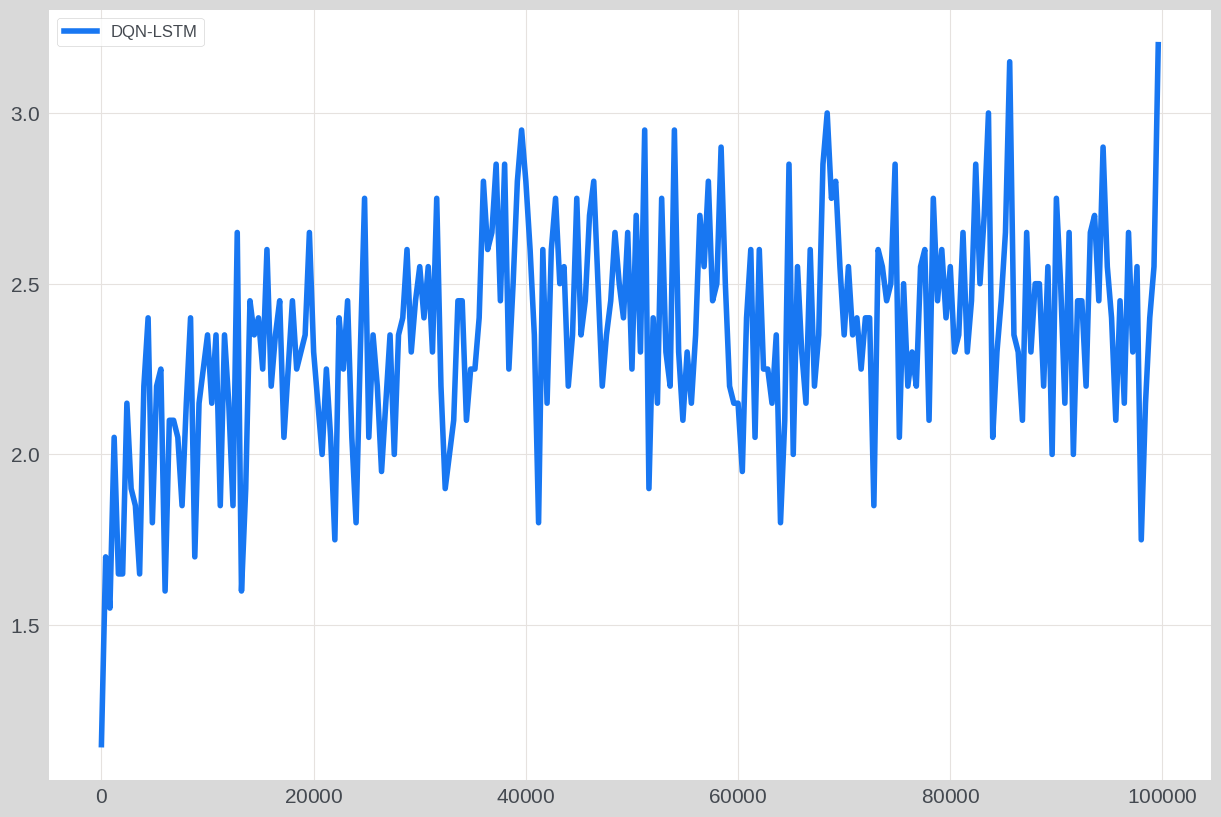

In [5]:
# Add a LSTM history summarization module

agent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=128,
        action_space=action_space,
        hidden_dims=[64, 64],
        training_rounds=50,
        action_representation_module=action_representation_module,
    ),
    history_summarization_module=LSTMHistorySummarizationModule(
        observation_dim=1,
        action_dim=100,
        hidden_dim=128,
        history_length=history_length,
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=device_id,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=min(record_period, number_of_steps),
    learn_after_episode=True,
)

torch.save(info["return"], "DQN-LSTM-return.pt")
plt.plot(
    record_period * np.arange(len(info["return"])),
    info["return"],
    label="DQN-LSTM",
)
plt.legend()
plt.show()


## Bootstrapped DQN Agent with LSTM History Summarization

Leveraging the deep exploration value-based algorithm, now the agent can achieve a better performance in a much faster way while being able to still leverage history summarization capability. Note how top average performance takes around 20,000 steps in the graph above, but only about 5,000 steps in the graph below.

episode 5, step 100, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=RecEnv
return: 2.0
episode 10, step 200, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=RecEnv
return: 0.0
episode 15, step 300, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=RecEnv
return: 2.0
episode 20, step 400, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=RecEnv
return: 2.0
episode 25, step 500, agent=PearlAgent with BootstrappedDQN, LSTMHistorySummarizationModule(
  (lstm): LSTM(101, 128, num_layers=2, batch_first=True)
), BootstrapReplayBuffer, env=RecEnv
return: 2.0
episod

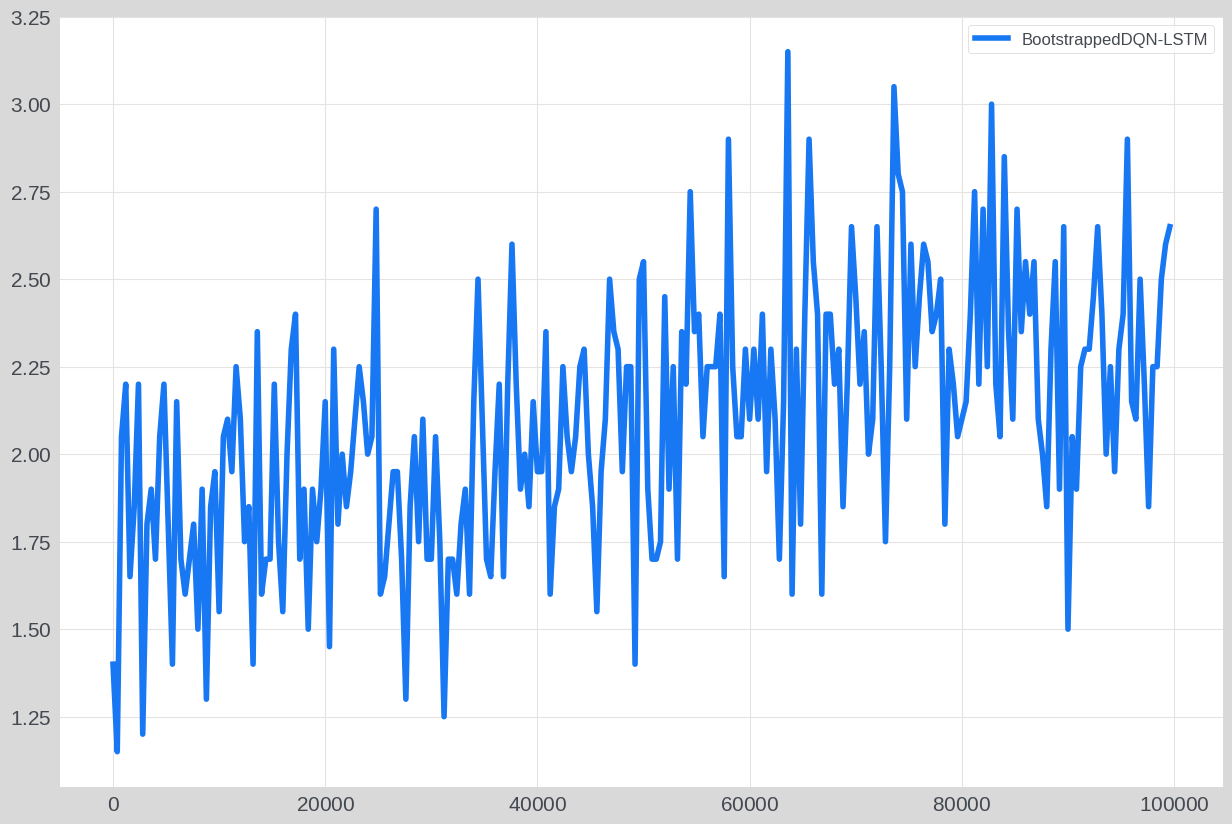

In [6]:
# Better exploration with BootstrappedDQN-LSTM

agent = PearlAgent(
    policy_learner=BootstrappedDQN(
        q_ensemble_network=EnsembleQValueNetwork(
            state_dim=128,
            action_dim=100,
            ensemble_size=10,
            output_dim=1,
            hidden_dims=[64, 64],
            prior_scale=0.3,
        ),
        action_space=action_space,
        training_rounds=50,
        action_representation_module=action_representation_module,
    ),
    history_summarization_module=LSTMHistorySummarizationModule(
        observation_dim=1,
        action_dim=100,
        hidden_dim=128,
        history_length=history_length,
    ),
    replay_buffer=BootstrapReplayBuffer(100_000, 1.0, 10),
    device_id=device_id,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=min(record_period, number_of_steps),
    learn_after_episode=True,
)

torch.save(info["return"], "BootstrappedDQN-LSTM-return.pt")
plt.plot(
    record_period * np.arange(len(info["return"])),
    info["return"],
    label="BootstrappedDQN-LSTM",
)
plt.legend()
plt.show()

## Summary
In this example, we illustrated Pearl's capability of dealing with dynamic action space, standard policy learning, history summarization and intelligent exploration, all in a single agent.
